In [1]:
from __future__ import division, print_function

import os
from datetime import datetime

# Ignore warnings
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from sklearn.metrics import average_precision_score

warnings.filterwarnings("ignore")


import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [89]:
%load_ext autoreload
%autoreload 2

from src.dataset import NodulesDataset
from src.augmentations import create_mip
from src.custom_models import resnet2d_bounded_relu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Prepare data

In [90]:
dataset = NodulesDataset("data/nodules")

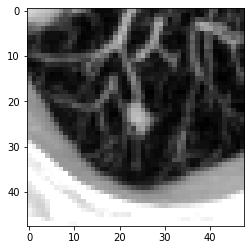

In [91]:
plt.imshow(create_mip(dataset[4][0]), cmap="gray")

In [92]:
dataset_to_visualize = NodulesDataset("data/nodules", transform=transforms.Compose([create_mip]))

In [93]:
def visualize_classes(dataset: Dataset, classes: list = [0, 1], columns: int = 6):
    np.random.seed(0)
    classes_ids = [0] * len(classes)
    for i, class_ in enumerate(classes):
        classes_ids[i] = np.random.choice(np.where(dataset.labels == class_)[0], columns, replace=False)
    f, ax = plt.subplots(len(classes), columns)
    f.set_size_inches(18.5, 10.5)
    for i in range(len(classes)):
        for j in range(columns):
            ax[i, j].set_title(f"id - {classes_ids[i][j]}; label - {dataset[classes_ids[i][j]][1]}")
            ax[i, j].imshow(dataset[classes_ids[i][j]][0], cmap="gray")
            ax[i, j].axis('off')

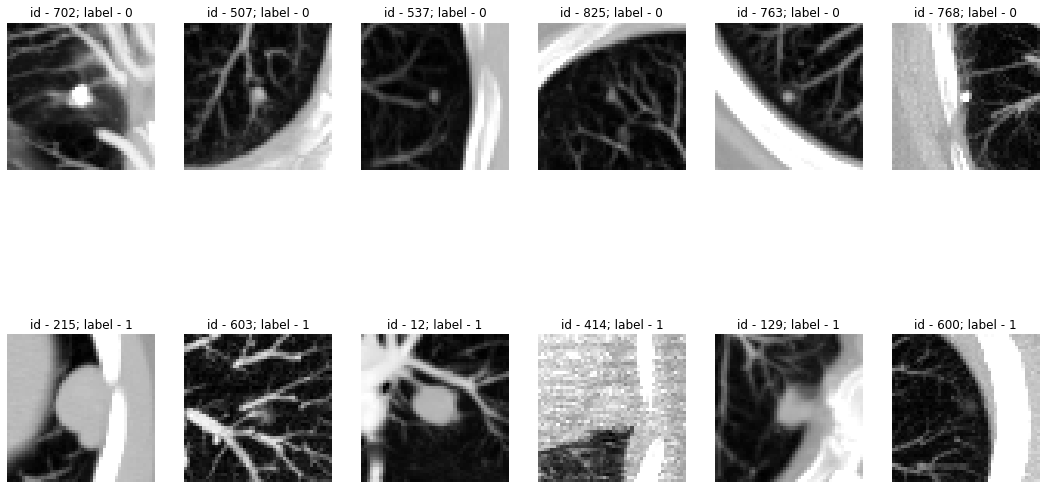

In [94]:
visualize_classes(dataset_to_visualize)

In [95]:
original_dataset = NodulesDataset(
    "data/nodules", 
    transform=transforms.Compose(
        [
            lambda x: x/255,
            lambda x: x[np.newaxis, :, :, :],
            lambda x: torch.tensor(x, dtype=torch.float32),
            lambda x: transforms.RandomHorizontalFlip(p=0.5)(x[0]).unsqueeze(0),
            lambda x: transforms.RandomVerticalFlip(p=0.5)(x[0]).unsqueeze(0),
#             transforms.ToTensor(),
#             lambda x: torchvision.transforms.functional.resize(x, 48),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
)

In [96]:
mean = np.mean([np.mean(sample[0][0].numpy()) for sample in original_dataset])
std = np.mean([np.std(sample[0][0].numpy()) for sample in original_dataset])
mean, std

(0.3011869, 0.25784153)

In [97]:
original_dataset = NodulesDataset(
    "data/nodules", 
    transform=transforms.Compose(
        [
#             lambda x: print(x.shape),
            lambda x: create_mip(x),
            lambda x: x/255,
#             lambda x: x + (np.random.normal(0,0.02,(48, 48)) * np.random.sample()),
#             lambda x: (x - mean) / std,
            lambda x: x[np.newaxis, :, :],
            lambda x: torch.tensor(x, dtype=torch.float32),
#             lambda x: transforms.RandomHorizontalFlip(p=0.5)(x[0]).unsqueeze(0),
#             lambda x: transforms.RandomVerticalFlip(p=0.5)(x[0]).unsqueeze(0),
#             transforms.ToTensor(),
#             lambda x: torchvision.transforms.functional.resize(x, 48),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
)

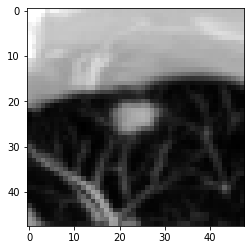

In [98]:
plt.imshow(original_dataset[0][0][0], cmap="gray")

In [99]:
original_dataset[0][0].dtype

torch.float32

In [100]:
train_size = int(0.8 * len(original_dataset))
test_size = len(original_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    original_dataset, [train_size, test_size], torch.Generator().manual_seed(0)
)

In [101]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=True, num_workers=2
)

In [102]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape, labels.shape

(torch.Size([32, 1, 48, 48]), torch.Size([32]))

In [103]:
dataloaders = {"train": train_loader, "val": test_loader}
dataset_sizes = {"train": len(train_dataset), "val": len(test_dataset)}

### Train model

In [108]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100.0
    best_epoch = 0
    writer = SummaryWriter()

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            probabilities = []
            full_labels = []
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    probabilities.extend(list(outputs.cpu().detach().numpy()[:, 1].reshape(-1)))

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                full_labels.extend(list(labels.cpu().detach().numpy()))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_ap = average_precision_score(full_labels, probabilities)

            if phase == "val":
                scheduler.step(epoch_loss)
            else:
                writer.add_scalar(f'LR/{phase}', optimizer.param_groups[0]["lr"], epoch)

            writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)
            writer.add_scalar(f'Accuracy/{phase}', epoch_acc, epoch)
            writer.add_scalar(f'Average precision/{phase}', epoch_ap, epoch)

            print("{} Loss: {:.4f} Acc: {:.4f} LR: {} AP: {}".format(phase, epoch_loss, epoch_acc, optimizer.param_groups[0]["lr"], epoch_ap))

            # deep copy the model
            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val loss: {:4f} Best epoch: {}".format(best_loss, best_epoch))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [109]:
device = "cuda:0"
# device = "cpu"

In [110]:
model_ft = resnet2d_bounded_relu.resnet18without_batch_norm()

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=0.001)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min', patience=5, eps=1e-05)

In [111]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50
)

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 0/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.6380 Acc: 0.6442 LR: 0.001 AP: 0.6968915759935068


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.6967 Acc: 0.5893 LR: 0.001 AP: 0.6994548167632412

Epoch 1/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.5136 Acc: 0.7922 LR: 0.001 AP: 0.8490535318121474


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.5670 Acc: 0.7440 LR: 0.001 AP: 0.7905000683792394

Epoch 2/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4771 Acc: 0.8296 LR: 0.001 AP: 0.9065299565968996


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.5471 Acc: 0.7440 LR: 0.001 AP: 0.8477577704472691

Epoch 3/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4538 Acc: 0.8550 LR: 0.001 AP: 0.9156705501396935


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.5119 Acc: 0.7917 LR: 0.001 AP: 0.8444151757642632

Epoch 4/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4709 Acc: 0.8356 LR: 0.001 AP: 0.9030949124720322


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.5643 Acc: 0.7202 LR: 0.001 AP: 0.8343795244048728

Epoch 5/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4497 Acc: 0.8595 LR: 0.001 AP: 0.9126383834833309


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4667 Acc: 0.8274 LR: 0.001 AP: 0.9177822238534632

Epoch 6/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4309 Acc: 0.8819 LR: 0.001 AP: 0.9256060602187062


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.5185 Acc: 0.7857 LR: 0.001 AP: 0.8417657728330379

Epoch 7/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4969 Acc: 0.8132 LR: 0.001 AP: 0.8880193896469977


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.5309 Acc: 0.7619 LR: 0.001 AP: 0.8532431985251892

Epoch 8/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4751 Acc: 0.8356 LR: 0.001 AP: 0.8956716124287151


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4670 Acc: 0.8452 LR: 0.001 AP: 0.8772914743524172

Epoch 9/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4421 Acc: 0.8714 LR: 0.001 AP: 0.9193564014970089


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.6840 Acc: 0.6071 LR: 0.001 AP: 0.7329089005747018

Epoch 10/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4864 Acc: 0.8221 LR: 0.001 AP: 0.8880762169655014


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.5075 Acc: 0.7976 LR: 0.001 AP: 0.8754580441625952

Epoch 11/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4333 Acc: 0.8729 LR: 0.001 AP: 0.9272899020618627


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4762 Acc: 0.8155 LR: 0.0001 AP: 0.8741732258126613

Epoch 12/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4070 Acc: 0.9058 LR: 0.0001 AP: 0.9445721760413911


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4623 Acc: 0.8452 LR: 0.0001 AP: 0.9015860617724539

Epoch 13/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3914 Acc: 0.9223 LR: 0.0001 AP: 0.9551613733545847


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4592 Acc: 0.8452 LR: 0.0001 AP: 0.905217133764753

Epoch 14/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3763 Acc: 0.9402 LR: 0.0001 AP: 0.9484545414271537


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4595 Acc: 0.8512 LR: 0.0001 AP: 0.9098824905848857

Epoch 15/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3678 Acc: 0.9477 LR: 0.0001 AP: 0.9392123241921746


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4585 Acc: 0.8512 LR: 0.0001 AP: 0.9142339182892105

Epoch 16/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3657 Acc: 0.9462 LR: 0.0001 AP: 0.9481939749432013


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4505 Acc: 0.8631 LR: 0.0001 AP: 0.9169252415245015

Epoch 17/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3640 Acc: 0.9492 LR: 0.0001 AP: 0.9607871865738936


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4550 Acc: 0.8571 LR: 0.0001 AP: 0.915620435868798

Epoch 18/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3591 Acc: 0.9552 LR: 0.0001 AP: 0.9460252112665964


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4521 Acc: 0.8631 LR: 0.0001 AP: 0.9150865546662657

Epoch 19/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3594 Acc: 0.9552 LR: 0.0001 AP: 0.9506083722222893


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4614 Acc: 0.8512 LR: 0.0001 AP: 0.9143209782233013

Epoch 20/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3578 Acc: 0.9567 LR: 0.0001 AP: 0.9435808481736643


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4572 Acc: 0.8571 LR: 0.0001 AP: 0.9126304549735176

Epoch 21/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3581 Acc: 0.9567 LR: 0.0001 AP: 0.9636305663149096


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4607 Acc: 0.8512 LR: 0.0001 AP: 0.9170296411136823

Epoch 22/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3602 Acc: 0.9537 LR: 0.0001 AP: 0.9451135095517832


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4542 Acc: 0.8631 LR: 1e-05 AP: 0.9155465771955458

Epoch 23/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3565 Acc: 0.9552 LR: 1e-05 AP: 0.9609759760451434


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4544 Acc: 0.8571 LR: 1e-05 AP: 0.9169295610478873

Epoch 24/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3547 Acc: 0.9581 LR: 1e-05 AP: 0.960659208983595


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4547 Acc: 0.8631 LR: 1e-05 AP: 0.9179808867817776

Epoch 25/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3556 Acc: 0.9581 LR: 1e-05 AP: 0.9573142762304695


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4536 Acc: 0.8571 LR: 1e-05 AP: 0.9182484644999047

Epoch 26/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3549 Acc: 0.9596 LR: 1e-05 AP: 0.943075087572541


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4533 Acc: 0.8571 LR: 1e-05 AP: 0.9180547461353723

Epoch 27/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3573 Acc: 0.9567 LR: 1e-05 AP: 0.9559053527164011


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4523 Acc: 0.8571 LR: 1e-05 AP: 0.9179389888069304

Epoch 28/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3533 Acc: 0.9596 LR: 1e-05 AP: 0.9496922582636022


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4520 Acc: 0.8571 LR: 1e-05 AP: 0.9170232000346866

Epoch 29/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3529 Acc: 0.9611 LR: 1e-05 AP: 0.9516637778519101


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4540 Acc: 0.8512 LR: 1e-05 AP: 0.9178827373464284

Epoch 30/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3553 Acc: 0.9567 LR: 1e-05 AP: 0.9543689481704306


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4508 Acc: 0.8631 LR: 1e-05 AP: 0.9162863699129815

Epoch 31/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3528 Acc: 0.9611 LR: 1e-05 AP: 0.9597990171525544


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4497 Acc: 0.8631 LR: 1e-05 AP: 0.9175827210321222

Epoch 32/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3531 Acc: 0.9596 LR: 1e-05 AP: 0.9537320539878631


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4509 Acc: 0.8571 LR: 1e-05 AP: 0.916386063693709

Epoch 33/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3540 Acc: 0.9581 LR: 1e-05 AP: 0.9478872481153041


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4532 Acc: 0.8571 LR: 1e-05 AP: 0.9156284216083419

Epoch 34/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3528 Acc: 0.9611 LR: 1e-05 AP: 0.9548823077483591


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4517 Acc: 0.8631 LR: 1e-05 AP: 0.9156897514657505

Epoch 35/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3539 Acc: 0.9596 LR: 1e-05 AP: 0.9549345845041423


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4525 Acc: 0.8571 LR: 1e-05 AP: 0.9151908798241082

Epoch 36/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3534 Acc: 0.9611 LR: 1e-05 AP: 0.952315243867994


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4549 Acc: 0.8571 LR: 1e-05 AP: 0.9156509811092887

Epoch 37/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3531 Acc: 0.9611 LR: 1e-05 AP: 0.9526907673276406


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4569 Acc: 0.8571 LR: 1e-05 AP: 0.9166783162521781

Epoch 38/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3528 Acc: 0.9611 LR: 1e-05 AP: 0.9528763071033534


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4566 Acc: 0.8571 LR: 1e-05 AP: 0.9168251282991406

Epoch 39/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3531 Acc: 0.9611 LR: 1e-05 AP: 0.9619804981987048


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4548 Acc: 0.8571 LR: 1e-05 AP: 0.9158016412711651

Epoch 40/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3538 Acc: 0.9596 LR: 1e-05 AP: 0.9545906364878778


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4568 Acc: 0.8571 LR: 1e-05 AP: 0.9157532001842535

Epoch 41/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3527 Acc: 0.9611 LR: 1e-05 AP: 0.9465040478577198


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4600 Acc: 0.8452 LR: 1e-05 AP: 0.9171070327289542

Epoch 42/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3522 Acc: 0.9611 LR: 1e-05 AP: 0.9624089249923454


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4602 Acc: 0.8512 LR: 1e-05 AP: 0.9166928571241757

Epoch 43/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3533 Acc: 0.9596 LR: 1e-05 AP: 0.9590155047908392


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4615 Acc: 0.8452 LR: 1e-05 AP: 0.9169879980337237

Epoch 44/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3548 Acc: 0.9581 LR: 1e-05 AP: 0.9570920851366159


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4625 Acc: 0.8512 LR: 1e-05 AP: 0.917505919241437

Epoch 45/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3506 Acc: 0.9626 LR: 1e-05 AP: 0.9585242890504209


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4631 Acc: 0.8452 LR: 1e-05 AP: 0.9173907692180382

Epoch 46/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3499 Acc: 0.9626 LR: 1e-05 AP: 0.9525481176842062


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4694 Acc: 0.8393 LR: 1e-05 AP: 0.9174125795263081

Epoch 47/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3507 Acc: 0.9626 LR: 1e-05 AP: 0.9498981155644363


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4675 Acc: 0.8452 LR: 1e-05 AP: 0.9192250099730274

Epoch 48/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3491 Acc: 0.9641 LR: 1e-05 AP: 0.958161786620171


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4636 Acc: 0.8512 LR: 1e-05 AP: 0.9182030779519222

Epoch 49/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3495 Acc: 0.9641 LR: 1e-05 AP: 0.9450064141739711


100%|██████████| 6/6 [00:00<00:00, 20.67it/s]

val Loss: 0.4598 Acc: 0.8512 LR: 1e-05 AP: 0.9192348113918871

Training complete in 0m 57s
Best val loss: 0.449651 Best epoch: 31


In [116]:
results = []
with torch.no_grad():
    for i, (input_, label) in tqdm(enumerate(original_dataset), total=len(original_dataset)):
        input_ = input_.to(device)
        labels = labels.to(device)
        output = model_ft(input_.unsqueeze(0))
        _, pred = torch.max(output, 1)

        results.append({
            "id": i,
            "prob": output.cpu().numpy()[0][1],
            "y_pred": pred.cpu().numpy()[0],
            "y_true": label,
        })

100%|██████████| 837/837 [00:03<00:00, 225.11it/s]


(array([432.,   1.,   0.,   0.,   0.,   2.,   1.,   0.,   0., 401.]),
 array([5.91420928e-07, 1.00000401e-01, 2.00000211e-01, 3.00000021e-01,
        3.99999830e-01, 4.99999640e-01, 5.99999450e-01, 6.99999260e-01,
        7.99999069e-01, 8.99998879e-01, 9.99998689e-01]),
 <BarContainer object of 10 artists>)

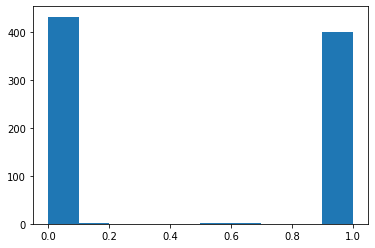

In [114]:
plt.hist(pd.DataFrame(results)["prob"])

In [115]:
save_path = f"models/resnet18_{datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}.pt"
torch.save(model_ft.state_dict(), save_path)
save_path

'models/resnet18_2021-04-02_03:41:13.pt'

In [19]:
model = custom_models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.load_state_dict(torch.load(save_path))
model.eval()

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)